In [57]:
import pystan
import stan_utility
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


1. Creating model predicting number of passenger deaths using poisson distribution in two variatns.

In [88]:
data = pd.read_csv("input.csv", sep = ';')

## generation of vector for plotting samples under histograms
dths=[]
dta_cnt=[]
for k in data['Passenger deaths']:  
    dta_cnt.append(-(1.+dths.count(k)))
    dths.append(k)
dta_cnt=np.array(dta_cnt)

data

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0
5,1981,21,362,0.06,6033.0
6,1982,26,764,0.13,5877.0
7,1983,20,809,0.13,6223.0
8,1984,16,223,0.03,7433.0
9,1985,22,1066,0.15,7107.0


Assuming that rate ($\lambda$) is constant for all years and independent on either year or miles flown, number of passengers deaths ($y_i$) has Poisson distribution:
$$y_i\sim\mathrm{Poisson}(\lambda)$$

Assuming that 10 people dying every day has very low probability (10*365=3650). Knowing that for poisson distribution $\lambda$ is mean and $\sqrt{\lambda}$ is standard deviation the following equasion have to be met:
$$\lambda+3\sqrt{\lambda}\approx3650$$
which means that probability is less than 1%.

In [59]:
root_of_lam=np.polynomial.polynomial.polyroots([-3650.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print("Calculated root: ")
print(lam_ub)

Calculated root: 
[3473.]


Using stan and algebra solver finding parameter ($\sigma$) of HalfNormal distributions that will fullify expected conditions. 

In [60]:
with open('prior_HN.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess;
  vector[1] theta;
}

transformed data {
  vector[1] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}


In [61]:
HN_model=stan_utility.compile_model('prior_HN.stan')
data=dict(y_guess=np.array([np.log(1000)]),theta=np.array(lam_ub))
HN_model_sampled = HN_model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(HN_model_sampled.extract()['sigma'][0])
print("Calculated sigma parameter value: ")
print(sigma)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8439126d8763a289564f7218b317b424 NOW.


Calculated sigma parameter value: 
1348.0


Drawing plot using calculated sigma value.

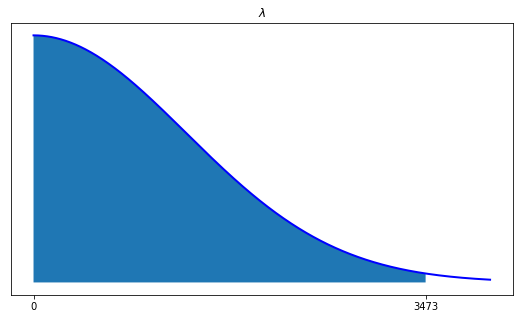

In [62]:
fig, ax2 = plt.subplots(1, 1,figsize=(9, 5))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color='blue',linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

Using stan for simulating outputs basing only on input data - from prior years.

In [63]:
with open('prior_pred.stan', 'r') as file:
    print(file.read())

data {
  int M;
}

generated quantities {
  real lambda=fabs(normal_rng(0,1348));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [64]:
pred_model=stan_utility.compile_model('prior_pred.stan')
R=1000
pred_model_sampled=pred_model.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)
params=pred_model_sampled.extract()
theta=params['lambda']
y_sim=params['y_sim']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9d4a7c41d23ed61b317ce2a07449c6e NOW.


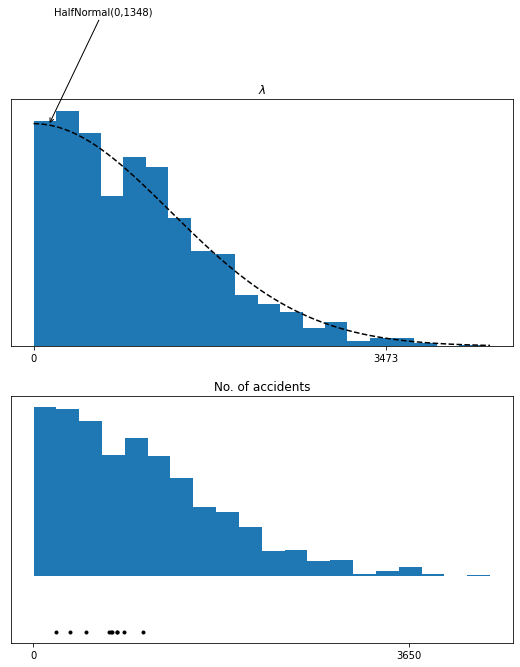

In [65]:
fig, axes = plt.subplots(2, 1,figsize=(9, 10))
ax1=axes[0]
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,4500,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),density=True,bins=20,zorder=1)
ax2.scatter(dths,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,3650])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

Posterior predicitive checks and inference.

In [66]:
with open('checks_const.stan', 'r') as file:
    print(file.read())

data {
  int M;
  int y[M];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,121);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [69]:
m_post=stan_utility.compile_model('checks_const.stan')
data = dict(M = len(data),
            y = data['Passenger deaths'])
fit = m_post.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

Using cached StanModel


In [70]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.95)
hpd_width=cinf_lam[1]-cinf_lam[0]

print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 688.68
89% confidence interval: [ 671.87 704.44 ]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


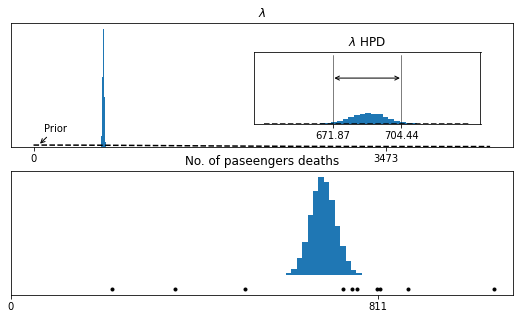

In [71]:
fig, axes = plt.subplots(2, 1,figsize=(9, 5))
ax1=axes[0]
ax1.hist(lam,bins=20,density=True)
x=np.linspace(0,4500,100)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),density=True,bins=20,zorder=1)
ax2.scatter(dths,0.002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of paseengers deaths')
plt.show()

Predicting the number of deaths with created model, knowing that, there were 546 of them in 1986.

In [72]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.95)

print('Median of predicted deaths =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted deaths = 689.0
Confidence interval = [ 635.0 742.0 ]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


Model has predicted close but higher value.

2.
Assuming that intensity ($\theta$) is constand but rate ($\lambda$) is product of intensity and miles flown ($\bar{n}$), number of passengers deaths ($y_i$) has Poisson distribution:
$$y_i\sim\mathrm{Poisson}(\lambda)$$
 
Assuming that 10 people dying every day has very low probability (10*365=3650), $\lambda=\theta\cdot\bar{n}$. This gives us condition
$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx3650$$
 
which means that probability is less than 1%.

In [75]:
mean_miles = np.mean(data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-3650/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

data=dict(y_guess=np.array([np.log(0.1)]),theta=np.array(theta_ub))
HN_model_sampled = HN_model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (HN_model_sampled.extract()['sigma'][0])
print('Calculated sigma: ')
print('sigma =','{:4.3f}'.format(sigma))

theta upper bound 0.608
Calculated sigma: 
sigma = 0.236


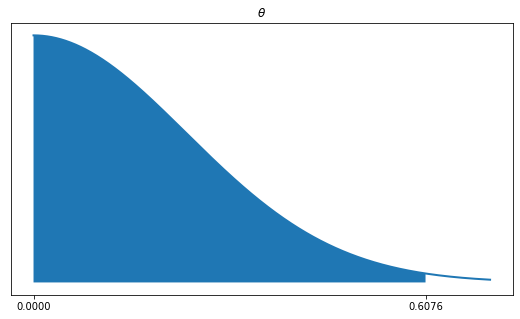

In [76]:
fig, ax2 = plt.subplots(1, 1,figsize=(9, 5))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_title(r'$\theta$')
plt.show()

Simulating outputs with stan using only prior data.

In [77]:
with open('prior_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
}
generated quantities {
  real theta=fabs(normal_rng(0,0.236));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}


In [80]:
model_prior=stan_utility.compile_model('prior_distance.stan')
R=1000
data_prior=dict(M=len(data),miles=data['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,seed=29042020)

Using cached StanModel


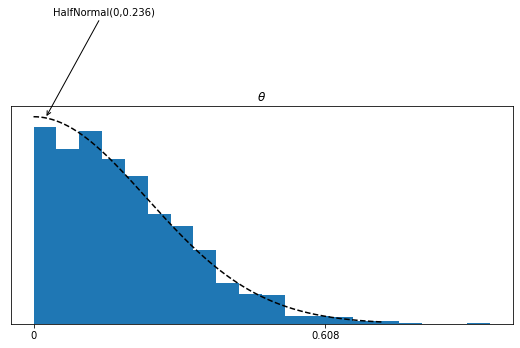

In [81]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(9, 4))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.025,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(0.025,arr_y_loc),xytext=(0.04,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

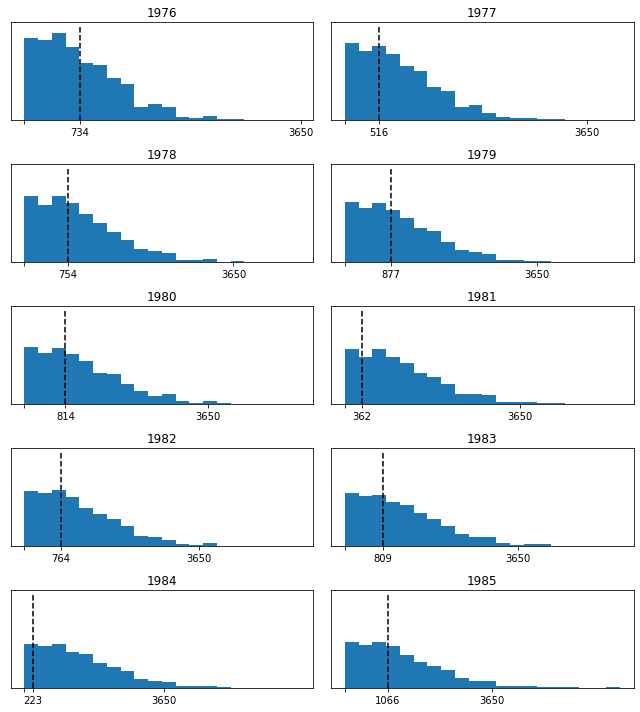

In [82]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(9, 10), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,density=True)
    ax.set_title(data['Year'][k])
    tv=data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.0009],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,3650])
    ax.set_xticklabels(['',tv,3650])

fig.tight_layout()

plt.show()

In [83]:
with open('checks_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
  int y[M];
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.021);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}


In [84]:
model_miles=stan_utility.compile_model('checks_distance.stan')
data = dict(M = len(data),
            miles = data['Miles flown [100 mln miles]'],
            y = data['Passenger deaths'])
fit = model_miles.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

Using cached StanModel


In [85]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.95)
hpd_width=cinf_theta[1]-cinf_theta[0]


print('Mean theta : {:5.4f}'.format(mean_theta))
print('95% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1205
95% confidence interval: [ 0.1179 0.1234 ]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


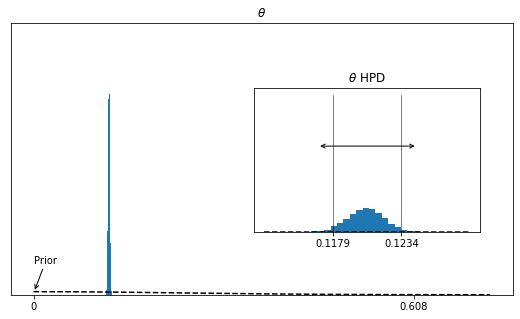

In [86]:
fig, axes = plt.subplots(1, 1,figsize=(9, 5))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],5000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.001,0,sigma)
ax1.annotate('Prior',xy=(0.001,arr_y_loc),xytext=(0.0015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

KeyError: ignored

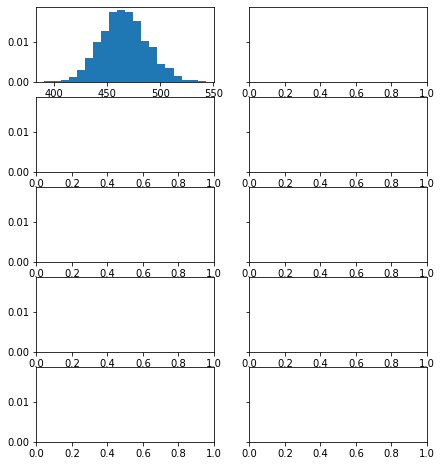

In [87]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,density=True)
    ax.set_title(data['Year'][k])
    tv=data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Finally, I will try to predict number of deaths in 1986. This time it is slightly more complicated as it requires modifying generated quantities block. There were 546 death and 0.06 death per 100 000 000 miles flown in 1986.

In [ ]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [ ]:
with open('prior_pred_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
  int y[M];
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.236);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}


In [ ]:
model1986=stan_utility.compile_model('prior_pred_distance.stan')

data = dict(M = len(data),
            miles = data['Miles flown [100 mln miles]'],
            y = data['Passenger deaths'])
fit1986 = model1986.sampling(data=data, seed=8052020)
y_1986=fit1986.extract()['y_1986']

median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.95)

print('Median of predicted deaths =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Using cached StanModel
Median of predicted deaths = 1101.0
Confidence interval = [ 1031.0 1170.0 ]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


Even taking more data into consideration, result is worse than the one received in task no. 1. This time over two times bigger value has been predicted.